In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size = 4

std_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

std_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=std_transforms)
trainloader = torch.utils.data.DataLoader(std_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=std_transforms)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# the order for cifar10 10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(device)
print(len(std_trainset))
print(len(trainloader))  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps
50000
12500


#### Optional: Apply data augmentation

In [6]:
from custom_nn.datasets import CustomCIFAR10

# Additional focused augmentations
focused_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# using custom dataset class to add focused augmentations capability
aug_trainset = CustomCIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=std_transforms,
    focused_transform=focused_augmentations
)

# the class we want the augmentation for birds, cats, deer, and dogs
desired_classes = [1, 2, 3, 4]

# Filter the dataset
filtered_indices = [i for i, (_, label) in enumerate(aug_trainset) if label in desired_classes]

filtered_dataset = torch.utils.data.Subset(aug_trainset, filtered_indices)

# Combine the two datasets
combined_trainset = torch.utils.data.ConcatDataset([std_trainset, filtered_dataset])
trainloader = torch.utils.data.DataLoader(combined_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
print(len(combined_trainset))
print(len(trainloader))


Files already downloaded and verified
70000
17500


In [7]:
from custom_nn.blocks import ResBlock, SkipConn2d, BottleneckResBlock

class ResMaxNoFCDelay(nn.Module):
    def __init__(self):
        super().__init__()
        
        ### RES 1
        
        # 3x32x32 to 10x32x32
        self.rb1 = ResBlock(3, 10, 1)
        self.act1 = nn.ReLU()

        ### RES 2

        # 10x32x32 to 20x32x32
        self.rb2 = ResBlock(10, 20, 1)
        self.act2 = nn.ReLU()

        
        ### RES 3
        # 20x32x32 to 30x32x32
        self.rb3 = ResBlock(20, 30, 1)
        self.act3 = nn.ReLU()
        
        ### RES 4
        # 30x32x32 to 40x32x32
        self.rb4 = ResBlock(30, 40, 1)
        self.act4 = nn.ReLU()

        
        ### RES 5
        # 40x32x32 to 50x32x32
        self.rb5 = ResBlock(40, 50, 1)
        self.act5 = nn.ReLU()
        # 50x32x32 to 50x16x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        ### RES 6
        # 50x16x16 to 60x16x16
        self.rb6 = ResBlock(50, 50, 1)
        self.act6 = nn.ReLU()
        # 20x16x16 to 20x8x18
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # we will do flatten height and width and then do global average pooling
        # affine operation from 20 neurons to output layer with 10 classes
        self.fc = nn.Linear(50, 10)
        
    def forward(self, x):

        x = self.rb1(x)
        x = self.act1(x)

        x = self.rb2(x)
        x = self.act2(x)
        
        x = self.rb3(x)
        x = self.act3(x)
        
        x = self.rb4(x)
        x = self.act4(x)
        
        x = self.rb5(x)
        x = self.act5(x)
        x = self.pool1(x)
        
        x = self.rb6(x)
        x = self.act6(x)
        x = self.pool2(x)
        
        # 4 (batch size) x 30 (channels) x 32 (height) x 32 (width)
        # change x from shape [batch_size, channels, height, width] 
        # to [batch_size, channels, height*width]
        x = x.view(x.shape[0], x.shape[1], -1)
        # global average pooling over the spatial dimensions in each feature map
        # becomes 4 x 100
        x = x.mean(dim=-1)
         
        x = self.fc(x)
        return x
    
test = ResMaxNoFCDelay()
test.to(device)
test(torch.randn(4, 3, 32, 32).to(device))

tensor([[-0.8758,  1.8651,  3.3281,  0.1660, -0.2042,  2.8783, -0.7516, -1.1446,
          0.3006,  0.4035],
        [-0.9666,  1.9619,  3.2912,  0.3375, -0.0665,  2.7744, -0.8244, -1.0901,
          0.3183,  0.3981],
        [-0.9602,  1.9375,  3.4419,  0.1979, -0.2388,  2.8107, -0.8358, -1.2021,
          0.1873,  0.4700],
        [-0.9060,  1.8346,  3.2285,  0.2776, -0.1555,  2.7762, -0.8070, -0.9690,
          0.2071,  0.4485]], device='mps:0', grad_fn=<LinearBackward0>)

In [8]:
from pathlib import Path
import time
from custom_nn.utils.model_utils import count_parameters, get_model_size

epoch_start = 0     # Start from epoch 0 or last checkpoint epoch
iter_n = len(trainloader)  # number of iteration per epoch
record_freq = 100 # how many times to record the loss and accuracy per epoch
print_freq = 100 # how many times to print the loss and accuracy per epoch
iter_n_per_record = iter_n // record_freq  # Record frequency.
iter_n_per_print = iter_n // print_freq # Print frequency, need to be multiple of record_freq.

# a number for computing running validation loss in each iteration.
train_per_valid = len(trainloader) / len(validloader)  

avg_train_losses, avg_valid_losses = [], []   # Avg. losses.
train_accuracies, valid_accuracies = [], []  # Train and test accuracies.
time_per_epoch = []  # Time per epoch.

model = ResMaxNoFCDelay()     # Create the network instance.
# Move the network parameters to the specified device
# need to be done before passing to optimizer.
model.to(device)  

assert model(torch.randn(4, 3, 32, 32).to(device)).shape == torch.Size([4, 10])

# We use Adam as optimizer.
opt = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss() 

# add scheduling
# scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)
# scheduler = optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=4, threshold=1e-4)

# directory to save the model
directory_path = Path("./checkpoints/res_max_no_fc_delay" + "_batch" + str(batch_size))
# Make the directory if it doesn't exist
directory_path.mkdir(parents=True, exist_ok=True)

print("train_per_valid:", train_per_valid)

print("number of parameters:", count_parameters(model))
print('model size: {:.4f}MB'.format(get_model_size(model)))


train_per_valid: 7.0
number of parameters: 136960
model size: 0.5268MB


In [9]:
import re

# Pattern to match the files and extract epoch numbers
pattern = r'epoch_(\d+).pth'

# Use Path.glob to list all files matching the pattern
files = list(directory_path.glob('epoch_*.pth'))

# Extract epochs and files into a list of tuples
epoch_files = []
for file_path in files:
    match = re.search(pattern, file_path.name)
    if match:
        epoch_num = int(match.group(1))
        epoch_files.append((epoch_num, file_path))

# Sort the list by epoch number in descending order
epoch_files.sort(key=lambda x: x[0], reverse=False)

if epoch_files:
    # populating history for loss and accuracy for plotting
    for file in epoch_files:
        checkpoint = torch.load(file[1])
        avg_train_losses += checkpoint['avg_train_losses']
        avg_valid_losses += checkpoint['avg_valid_losses']
        train_accuracies.append(checkpoint['train_accuracy'])
        valid_accuracies.append(checkpoint['valid_accuracy'])
        time_per_epoch.append(checkpoint['time_per_epoch'])
    
    # load the model from the latest checkpoint file
    latest_file_path = epoch_files[-1][1]
    print(f"The latest checkpoint file is: {latest_file_path}")
    checkpoint = torch.load(latest_file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # start training from the next epoch
    epoch_start = checkpoint['epoch'] + 1
else:
    print("No checkpoint files found.")
        

No checkpoint files found.


In [10]:
epochs = 10  # Total epochs.

for epoch in range(epoch_start, epoch_start + epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    running_val_loss = 0.0     # Initialize running train_loss for validation set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    valid_total = 0   
    valid_correct = 0
    
    
    
    print('--> [Start of epoch {}]'.format(epoch) +
          '  lr: {:.6f}'.format(opt.param_groups[0]['lr']))
    
    # print('--> [Start of epoch {}]'.format(epoch))
    
    epoch_start_time = time.time()
    
    validiter = iter(validloader)
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Set the model to training mode.
        model.train()
        
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = model(inputs)
        train_loss = loss_func(train_output, labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        model.eval()
        
        # record statistics.
        running_train_loss += train_loss.item()
        
        # this is for recording training accuracy
        _, train_predicted = torch.max(train_output.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()
        
        # only iterate through validation set according to train_per_valid ratio
        if i % train_per_valid == train_per_valid - 1:
            # Set the model to evaluation mode.
            with torch.no_grad():
                valid_inputs, valid_labels = next(validiter)
                valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                valid_output = model(valid_inputs)
                valid_loss = loss_func(valid_output, valid_labels)
                running_val_loss += valid_loss.item()
                
                _, valid_predicted = torch.max(valid_output.data, 1)
                valid_total += valid_labels.size(0)
                valid_correct += (valid_predicted == valid_labels).sum().item()
            
        # Record training/validation loss every several mini-batches.
        if i % iter_n_per_record == iter_n_per_record - 1: 
            avg_train_loss = running_train_loss / iter_n_per_record
            avg_train_losses.append(avg_train_loss)
            avg_valid_loss = train_per_valid * running_val_loss / iter_n_per_record
            avg_valid_losses.append(avg_valid_loss)
            running_train_loss, running_val_loss = 0.0, 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % iter_n_per_print == iter_n_per_print - 1:
                print('[epoch: {}, i: {:5d}]'.format(epoch, i) +
                      '  train_loss: {:.3f}'.format(avg_train_loss) + 
                      '  |  valid_loss: {:.3f}'.format(avg_valid_loss))
                            
    epoch_end_time = time.time()
    time_per_epoch.append(epoch_end_time - epoch_start_time)
    
    # calculating train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    valid_accuracy = 100 * valid_correct / valid_total
    valid_accuracies.append(valid_accuracy)     
    
    # reduce on plateau scheduling
    scheduler.step(valid_accuracy)
    
    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    file_name = f'epoch_{epoch:04d}.pth'
    save_path = directory_path / file_name
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'avg_train_losses': avg_train_losses[epoch * iter_n_per_record : (epoch + 1) * iter_n_per_record],
            'avg_valid_losses': avg_valid_losses[epoch * iter_n_per_record : (epoch + 1) * iter_n_per_record],
            'train_accuracy': train_accuracies[epoch],
            'valid_accuracy': valid_accuracies[epoch],
            'time_per_epoch': time_per_epoch[epoch],
            }, save_path)
    
    print('--> [End of epoch {}]'.format(epoch) +
                      ' train_accuracy: {:.2f}%'.format(train_accuracy) + 
                      '  |  valid_accuracy: {:.2f}%'.format(valid_accuracy))

print('Finished Training.')

--> [Start of epoch 0]  lr: 0.000500


[epoch: 0, i:   174]  train_loss: 2.217  |  valid_loss: 2.396
[epoch: 0, i:   349]  train_loss: 1.969  |  valid_loss: 2.172
[epoch: 0, i:   524]  train_loss: 1.929  |  valid_loss: 2.094
[epoch: 0, i:   699]  train_loss: 1.924  |  valid_loss: 1.947
[epoch: 0, i:   874]  train_loss: 1.907  |  valid_loss: 1.848
[epoch: 0, i:  1049]  train_loss: 1.815  |  valid_loss: 1.912
[epoch: 0, i:  1224]  train_loss: 1.779  |  valid_loss: 1.935
[epoch: 0, i:  1399]  train_loss: 1.760  |  valid_loss: 1.765
[epoch: 0, i:  1574]  train_loss: 1.759  |  valid_loss: 1.785
[epoch: 0, i:  1749]  train_loss: 1.746  |  valid_loss: 1.599
[epoch: 0, i:  1924]  train_loss: 1.709  |  valid_loss: 1.803
[epoch: 0, i:  2099]  train_loss: 1.698  |  valid_loss: 1.736
[epoch: 0, i:  2274]  train_loss: 1.645  |  valid_loss: 1.708
[epoch: 0, i:  2449]  train_loss: 1.674  |  valid_loss: 1.781
[epoch: 0, i:  2624]  train_loss: 1.601  |  valid_loss: 1.517
[epoch: 0, i:  2799]  train_loss: 1.601  |  valid_loss: 1.655
[epoch: 

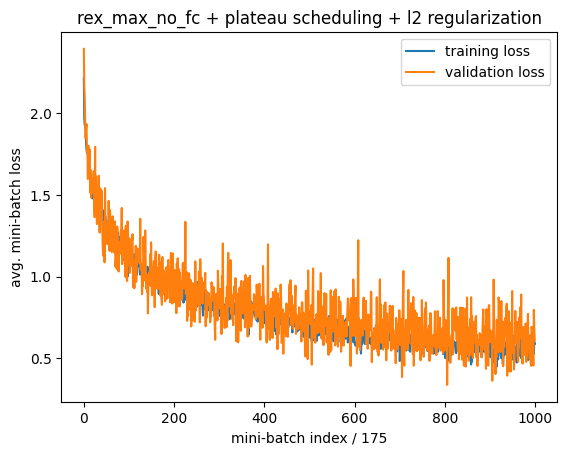

In [11]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('rex_max_no_fc + plateau scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(iter_n_per_record))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

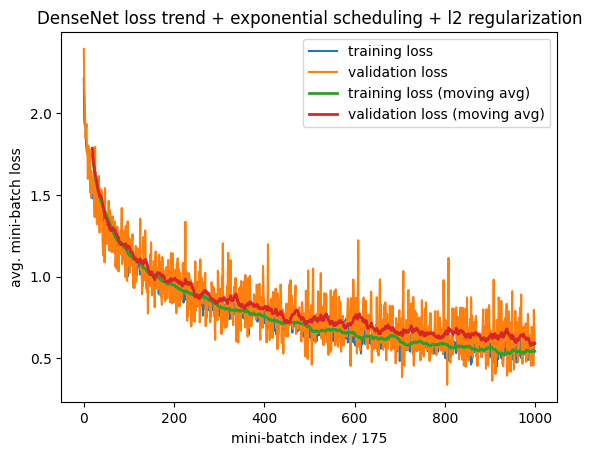

In [12]:
def moving_average(data, window_size):
    """Compute the moving average of the data using a specified window size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 20  # Adjust this based on your preference
train_losses_ma = moving_average(avg_train_losses, window_size)
valid_losses_ma = moving_average(avg_valid_losses, window_size)

# x_axis = np.arange(len(train_losses_ma))/100 
x_axis = np.arange(window_size - 1, len(train_losses_ma) + window_size - 1)

plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.plot(x_axis, train_losses_ma, linewidth=2)
plt.plot(x_axis, valid_losses_ma, linewidth=2)
plt.title('DenseNet loss trend + exponential scheduling + l2 regularization')
plt.xlabel('mini-batch index / {}'.format(iter_n_per_record))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss', 'training loss (moving avg)', 'validation loss (moving avg)'])
plt.show()

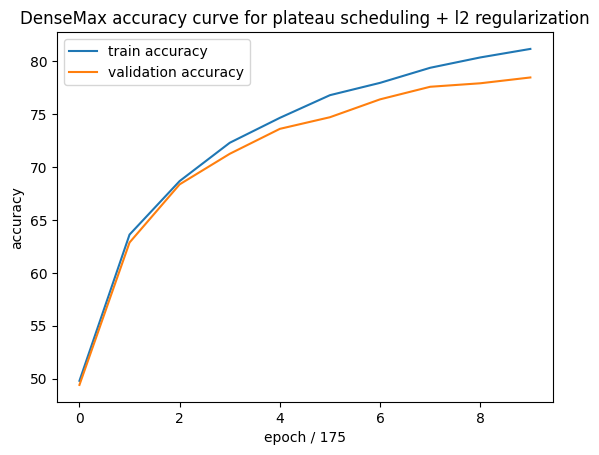

In [13]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title('DenseMax accuracy curve for plateau scheduling + l2 regularization')
plt.xlabel('epoch / {}'.format(iter_n_per_record))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [14]:
# print average time per epoch to 2nd decimal place
print(f"Average time per epoch: {np.mean(time_per_epoch):.2f} seconds")
print("number of parameters:", count_parameters(model))
print(f'model size: {get_model_size(model):.3f}MB')

Average time per epoch: 817.60 seconds
number of parameters: 136960
model size: 0.527MB


In [15]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

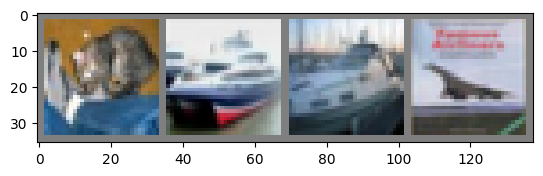

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [16]:
# Check several images.
dataiter = iter(validloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [17]:
images, labels = next(iter(validloader))
print(len(images))

4


In [18]:
inference_time_per_image = []


model.to(device)
model.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        inference_start = time.time()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        inference_end = time.time()
        inference_time_per_image.append((inference_end - inference_start) / len(images))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

# print average inference time per image in ms
print(f"average inference time per image: {sum(inference_time_per_image) * 1000 / len(inference_time_per_image):.3f} ms")

Accuracy of the network on the 10000 test images: 80.27 %
average inference time per image: 1.203 ms


In [54]:
model.to(device)
model.eval()

# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 91 %
Accuracy of  bird : 74 %
Accuracy of   cat : 61 %
Accuracy of  deer : 81 %
Accuracy of   dog : 77 %
Accuracy of  frog : 83 %
Accuracy of horse : 80 %
Accuracy of  ship : 85 %
Accuracy of truck : 87 %
